In [1]:
%matplotlib inline
import re
from time import time
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from math import sqrt, log

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import os; import json; import fileinput

fileinput.close() # sometimes fileinput is already active
def load_file(filename, max_lines = 150000):
    headers = None
    data = []
    for line in fileinput.input(filename):
        line = line.replace('\n', '')
        # Change separator between ""
        line = re.sub("\"[^\"]*\"", lambda x:x.group(0).replace(',',';'), line)
        line = line.split(',')
        if not headers:
            headers = line
            continue

        data.append(line)
        if len(data) > max_lines: break #and filename != 'test.csv': break
            
    fileinput.close()
    return headers, np.array(data)

h_train, df = load_file("train.csv", max_lines=1000000)
df_train = pd.DataFrame(df, columns=h_train)#.sample(200000)
h_train, df = load_file("test.csv", max_lines=1000000)
df_test = pd.DataFrame(df, columns=h_train)#.sample(200000)

df_train['Dates'] = df_train['Dates'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
#df_train['Resolution'] = df_train['Resolution'].apply(lambda x: x.replace('"', '').split('; '))
df_test['Dates'] = df_test['Dates'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
#df_test['Resolution'] = df_test['Resolution'].apply(lambda x: x.replace('"', '').split('; '))

df_train.columns

Index(['Dates', 'Category', 'Descript', 'DayOfWeek', 'PdDistrict',
       'Resolution', 'Address', 'X', 'Y'],
      dtype='object')

total data:  877982
Done in 10.01 min.
Index(['X', 'Y', 'day', 'summer', 'fall', 'winter', 'spring', 'X_-122.44',
       'Y_37.76', 'XY',
       ...
       'Add_140_16TH ST / MISSION ST', 'Add_141_400 Block of ELLIS ST',
       'Add_142_300 Block of ELLIS ST', 'Add_143_0 Block of 6TH ST',
       'Add_144_0 Block of TURK ST', 'Add_145_900 Block of MARKET ST',
       'Add_146_1000 Block of POTRERO AV', 'Add_147_2000 Block of MISSION ST',
       'Add_148_800 Block of MARKET ST', 'Add_149_800 Block of BRYANT ST'],
      dtype='object', length=203)
Index(['X', 'Y', 'day', 'summer', 'fall', 'winter', 'spring', 'X_-122.44',
       'Y_37.76', 'XY',
       ...
       'Add_140_16TH ST / MISSION ST', 'Add_141_400 Block of ELLIS ST',
       'Add_142_300 Block of ELLIS ST', 'Add_143_0 Block of 6TH ST',
       'Add_144_0 Block of TURK ST', 'Add_145_900 Block of MARKET ST',
       'Add_146_1000 Block of POTRERO AV', 'Add_147_2000 Block of MISSION ST',
       'Add_148_800 Block of MARKET ST', 'Add_149

,X,Y,day,summer,fall,winter,spring,X_-122.44,Y_37.76,XY,...,Add_140_1000 Block of MARKET ST,Add_141_400 Block of ELLIS ST,Add_142_300 Block of ELLIS ST,Add_143_0 Block of 6TH ST,Add_144_0 Block of TURK ST,Add_145_900 Block of MARKET ST,Add_146_1000 Block of POTRERO AV,Add_147_2000 Block of MISSION ST,Add_148_800 Block of MARKET ST,Add_149_800 Block of BRYANT ST
242848,0.440905,0.667372,8,0,0,0,1,0.709623,0.772047,-4625.097811,...,0,0,0,0,0,0,0,0,0,0
51045,-1.899557,-2.070484,6,0,1,0,0,0.000000,0.000000,-4619.231154,...,0,0,0,0,0,0,0,0,0,0
521546,-2.677657,-1.189740,8,0,0,1,0,0.000000,0.000000,-4622.580138,...,0,0,0,0,0,0,0,0,0,0


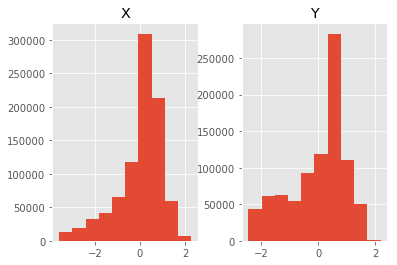

In [2]:
# Feature engineering
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler

st = time()
def get_season(x):
    summer=0; fall=0; winter=0; spring=0
    if (x in [5, 6, 7]):
        summer=1
    if (x in [8, 9, 10]):
        fall=1
    if (x in [11, 0, 1]):
        winter=1
    if (x in [2, 3, 4]):
        spring=1
    return summer, fall, winter, spring

def prepare_df(df):
    df['month'] = df['Dates'].apply(lambda x: x.month)
    df['year'] = df['Dates'].apply(lambda x: x.year)
    # don't use .day because test/data set split is from every other 2 weeks of the whole data
    df['day'] = df['Dates'].apply(lambda x: x.day)
    df['X'] = pd.to_numeric(df['X'])
    df['Y'] = pd.to_numeric(df['Y'])
    
    # Season
    df["summer"], df["fall"], df["winter"], df["spring"] = zip(*df["month"].apply(get_season))
    
    """
    N = 10
    DIST = (df['X'].max() - df['X'].min()) / N #0.08 # gives best score
    for lmin in np.arange(df['X'].min(), df['X'].max(), DIST):
        lmax = min(lmin + DIST, df['X'].max())
        df['X_' + str(lmin)] = df['X'].apply(lambda x: (x-lmin)/(lmax-lmin) if lmin <= x <= lmax else 0)
        #df['X_' + str(lmin) + '_NOT'] = df['X'].apply(lambda x: 0 if lmin <= x <= lmax else 1)
    DIST = (df['Y'].max() - df['Y'].min()) / N
    for lmin in np.arange(df['Y'].min(), df['Y'].max(), DIST):
        lmax = min(lmin + DIST, df['Y'].max())
        df['Y_' + str(lmin)] = df['Y'].apply(lambda x: (x-lmin)/(lmax-lmin) if lmin <= x <= lmax else 0)
        #df['Y_' + str(lmin) + '_NOT'] = df['Y'].apply(lambda x: 0 if lmin <= x <= lmax else 1)
    """
    for lmin, lmax in [(-122.44, -122.40)]:
        df['X_' + str(lmin)] = df['X'].apply(lambda x: (x-lmin)/(lmax-lmin) if lmin <= x <= lmax else 0)
        #df['X_' + str(lmin) + '_NOT'] = df['X'].apply(lambda x: 0 if lmin <= x <= lmax else 1)
    for lmin, lmax in [(37.76, 37.79)]:
        df['Y_' + str(lmin)] = df['Y'].apply(lambda x: (x-lmin)/(lmax-lmin) if lmin <= x <= lmax else 0)
        #df['Y_' + str(lmin) + '_NOT'] = df['Y'].apply(lambda x: 0 if lmin <= x <= lmax else 1)
    df['XY'] = df['X'] * df['Y']

    # Encode
    df = pd.get_dummies(df, columns=['month', 'year', 'DayOfWeek', 'PdDistrict'])
    # 'Category' will be encoded later
    # This sets two categories as 1 when both are in the column
    #df = df.merge(df['Resolution'].str.join(sep=';').str.get_dummies(sep=';').add_prefix('Res_'), left_index=True, right_index=True)
    #df.drop(['Resolution'], axis=1, inplace=True)
    
    df["IsInterection"] = df["Address"].apply(lambda x: 1 if "/" in x else 0)

    # Memory optimization
    # Technical stuff, contributes nothing to analysis
    conv = df.select_dtypes(include=['int', 'float']).apply(pd.to_numeric,downcast='unsigned')
    df[conv.columns] = conv
    return df

# Remove copy to save memory
df = prepare_df(df_train.copy(deep=True))
df_test_sub = prepare_df(df_test.copy(deep=True))

# Remove rows with wrong X/Y
df = df[df['X'] < -120.5]
df = df[df['Y'] < 60]
xy_scaler = StandardScaler()
xy_scaler.fit(df[["X","Y"]])
df[["X","Y"]] = xy_scaler.transform(df[["X","Y"]])
df_test_sub[["X","Y"]] = xy_scaler.transform(df_test_sub[["X","Y"]])

# Prepare for training
X = df.drop(['Dates', 'Resolution',
             # Text
             'Descript', 'Category', #'Address'
              ], axis=1)
#y = pd.get_dummies(df['Category'])
X_test_sub = df_test_sub.drop(['Dates', 'Id',
             # Text
             #'Address'
              ], axis=1)
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
y = enc.fit_transform(df['Category'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
print("total data: ", len(X))

# This doesn't help with new addresses introduced in the test set
# TODO use bayes
def add_addresses(df, addresses=None):
    num_all = len(df)
    #num_cats = df.groupby('Category').size().to_dict()
    # Addresses with highest count, doesn't give a pattern -> probably no useful information
    if addresses is None:
        addresses = list(df.groupby(['Address']).size().reset_index().sort_values([0])['Address'][-150:]) # was -60:
    for i, add in enumerate(addresses):
        df['Add_' + str(i) + '_' + add] = 0
        num_add = len(df[df['Address'] == add])
        #df[df['Address'] == add]['Add_' + str(i) + '_' + add] = df.apply(lambda x: num_cats[x['Category']] * num_add/num_all)
        df[df['Address'] == add]['Add_' + str(i) + '_' + add] = num_add / num_all
    df.drop(['Address'], axis=1, inplace=True)
    return addresses, df

addresses, X_train = add_addresses(X_train)
addresses, X_test = add_addresses(X_test, addresses)

addresses, X = add_addresses(X)
addresses, X_test_sub = add_addresses(X_test_sub, addresses)

df.hist(['X', 'Y'])
print('Done in {:.2f} min.'.format((time() - st)/60))
print(X.columns)
print(X_test_sub.columns)
#del X_test_sub
#df.info()
#df.head(10)[['Address']]
X_train.head(3)

In [3]:
#df_train.groupby('Category').size().to_dict()

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, log_loss
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

st = time()
pipe = Pipeline([
    ('scaler', StandardScaler()),
    # Score: 0.2301 , small set: 0.2361
    # all data: 0.2311
    ('model', LogisticRegression(C=100, max_iter=10, warm_start=True, n_jobs=-1)),
])

pipe2 = Pipeline([ # has bad generalization (worse score on website)
    ('scaler', StandardScaler()),
    # Score: 0.2251
    # all data: 0.2248
    ('pca', PCA(n_components=29)),
    ('model', LogisticRegression(C=100, max_iter=10, warm_start=True, n_jobs=-1))
    # Score: 0.2497
    #('model', RandomForestClassifier(n_estimators=20, max_depth=15, warm_start=True, n_jobs=-1))
])
# Score: 0.23140  , all data: 0.2292
eclf = VotingClassifier(estimators=[('log1', pipe), ('log2', pipe2)], voting='soft', weights=[1,2], n_jobs=-1)

if False:
    #eclf.fit(X_train, y_train)
    #print("Score:", eclf.score(X_test, y_test))
    
    pipe.fit(X_train, y_train)
    print("Score:", pipe.score(X_test, y_test))

if False:
    from sklearn.model_selection import GridSearchCV
    param_grid = {
        'pca__n_components': [28, 29, 30],
        #'model__max_iter': [10, 50, 100],
        #'model__warm_start': [True, False]
        #'model__C': [1e2, 1e1, 1e0]
                 }
    grid = GridSearchCV(pipe, param_grid, cv=2, n_jobs=-1)
    grid.fit(X_train, y_train)
    print(grid.best_params_)
    
print('Done in {:.2f} min.'.format((time() - st)/60))

In [ ]:
# Don't use this for data analysis! It's a tool for model analysis only
# It's wrong when using PCA
#print((y_pred_proba[0]))
#print((np.array(pd.get_dummies(y_test))[0]))

features = {}
try:
    #scores = pipe.named_steps['model'].feature_importances_
    scores = np.absolute(pipe.named_steps['model'].coef_).sum(axis=0)
    i=0
    for col in X.columns:
        features[col] = scores[i]
        i+=1     
except Exception as e:
    print(e)
    pass

# Print the best ones
import operator
features_sorted = sorted(features.items(), key=operator.itemgetter(1), reverse=True)
for f, v in features_sorted: #[:50]:
    print("{}: {:.5f}".format(f, v))
#features_sorted

In [6]:
# For submission
st = time()
pipe.fit(X, y)
print('{:.2f} min. trained'.format((time() - st)/60))
#y_pred_sub = pipe.predict(X_test_sub)
y_pred_proba = pipe.predict_proba(X_test_sub)
#preds = np.zeros((len(X_test_sub), len(y_pred_proba)))
#for i_class in range(0, len(y_pred_proba)):
#    for i_row in range(0, len(X_test)):
#        if y_pred_proba[i_class][i_row, 0] < 1:
#            preds[i_row][i_class] = y_pred_proba[i_class][i_row, 1]
#        else:
#            preds[i_row][i_class] = 0
y_pred_sub = y_pred_proba # preds
print('{:.2f} min. done.'.format((time() - st)/60))

11.75 min. trained
11.90 min. done.


In [7]:
columns = 'Id,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,EXTORTION,FAMILY OFFENSES,FORGERY/COUNTERFEITING,FRAUD,GAMBLING,KIDNAPPING,LARCENY/THEFT,LIQUOR LAWS,LOITERING,MISSING PERSON,NON-CRIMINAL,OTHER OFFENSES,PORNOGRAPHY/OBSCENE MAT,PROSTITUTION,RECOVERED VEHICLE,ROBBERY,RUNAWAY,SECONDARY CODES,SEX OFFENSES FORCIBLE,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS'.split(',')
#print(len(columns))
#print(len(y_pred_sub[0]))
ids = list(range(0, len(df_test_sub)))

import csv
csvfile = open('submission.csv', 'w')
writer = csv.writer(csvfile)
writer.writerow(columns)
for i in range(0, len(df_test_sub)):
    if i%200000==0: print("{:.0f}%".format(i / len(df_test_sub) * 100))
    row = y_pred_sub[i].round(decimals=6) # round to reduce size of submission.csv
    writer.writerow([i] + list(row))

csvfile.close()
print("Finished.")

0%
23%
45%
68%
90%
Finished.


In [8]:
pipe.score(X_test, y_test)

0.23118627079696918

### Summary

There are a lot of possibilities for small improvements: 
* PCA on addresses only.
* Log probability for all addresses. etc.
* More grid search cross validation over parameters. Lots of parameters are not optimized.